In [95]:
# Importing required libraries
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

In [84]:
imb = pd.read_csv("../data/imbalance_1h.csv")

In [86]:
imb = imb.set_index('datetime')

In [90]:
imb.drop(['2', 'weekday', 'date'], axis=1, inplace=True)

In [66]:
# import data
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

# convert 'datetime' to datetime object
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# reset index
train = train.set_index('datetime')
test = test.set_index('datetime')

# rename column
train.rename(columns={'1': 'imbalance_price'}, inplace=True)
test.rename(columns={'1': 'imbalance_price'}, inplace=True)

# convert to Series
#train_series = train.squeeze()
#test = test.squeeze()

In [67]:
train.head()

,imbalance_price
datetime,
2013-12-31 23:00:00,917.118
2014-01-01 00:00:00,1264.266
2014-01-01 01:00:00,746.810
2014-01-01 02:00:00,-15.512
2014-01-01 03:00:00,-36.904


In [68]:
train.imbalance_price

datetime
2013-12-31 23:00:00     917.118
2014-01-01 00:00:00    1264.266
2014-01-01 01:00:00     746.810
2014-01-01 02:00:00     -15.512
2014-01-01 03:00:00     -36.904
                         ...   
2019-03-05 01:00:00     147.278
2019-03-05 02:00:00     -28.272
2019-03-05 03:00:00    -201.291
2019-03-05 04:00:00      83.710
2019-03-05 05:00:00    -102.683
Name: imbalance_price, Length: 45343, dtype: float64

<Figure size 1008x576 with 0 Axes>

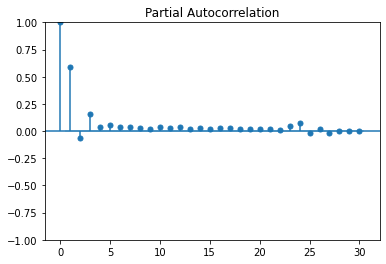

In [69]:
# Partial Autocorrelation Plot
plt.figure(figsize=(14, 8))
pacf = plot_pacf(train, lags=30, alpha=0.05)

Conclusion: AR(3)

<Figure size 1008x576 with 0 Axes>

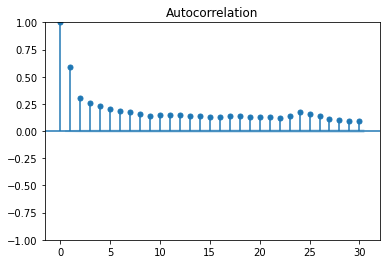

In [82]:
# Autocorrelation Plot
plt.figure(figsize=(14, 8))
pacf = plot_acf(train, lags=30)

Conclusion: MA between 3 and 10

In [ ]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()

In [72]:
train.head()

,imbalance_price
datetime,
2013-12-31 23:00:00,917.118
2014-01-01 00:00:00,1264.266
2014-01-01 01:00:00,746.810
2014-01-01 02:00:00,-15.512
2014-01-01 03:00:00,-36.904


In [73]:
train.shape

(45343, 1)

In [74]:
test.shape

(19433, 1)

In [166]:
model = ARIMA(train, order=(3,1,1))
results = model.fit()
results.aic

663273.1455304616

In [167]:
forecast = results.forecast(steps=1)

In [168]:
# RMSE
rmse = np.sqrt(mean_squared_error(test.iloc[0:1], forecast))
rmse

182.46446473031253

In [172]:
# define ranges for p, d, q
p_range = range(0,6)
d_range = range(0,2)
q_range = range(0,11)

In [173]:
for p in p_range:
    for d in d_range:
        for q in q_range:
            order = (p,d,q)
            model = ARIMA(train, order=order)
            model_fit = model.fit()
            pred_y = model_fit.forecast(steps=1)
            error = np.sqrt(mean_squared_error(test.iloc[0:1], pred_y))
            print(f'ARIMA {order} RMSE = {error}')

ARIMA (0, 0, 0) RMSE = 449.99952821851883
ARIMA (0, 0, 1) RMSE = 318.9020279380302
ARIMA (0, 0, 2) RMSE = 306.19387015178654
ARIMA (0, 0, 3) RMSE = 323.71685920916724
ARIMA (0, 0, 4) RMSE = 277.7764368214319
ARIMA (0, 0, 5) RMSE = 306.32442519991946
ARIMA (0, 0, 6) RMSE = 293.2129665499516
ARIMA (0, 0, 7) RMSE = 281.92655723585875
ARIMA (0, 0, 8) RMSE = 274.23694850549725
ARIMA (0, 0, 9) RMSE = 278.4899140347136
ARIMA (0, 0, 10) RMSE = 267.40559095068835
ARIMA (0, 1, 0) RMSE = 247.216
ARIMA (0, 1, 1) RMSE = 297.4691209860101
ARIMA (0, 1, 2) RMSE = 295.36864991941707
ARIMA (0, 1, 3) RMSE = 250.31208432994066
ARIMA (0, 1, 4) RMSE = 238.37698807715321
ARIMA (0, 1, 5) RMSE = 197.5106547183348
ARIMA (0, 1, 6) RMSE = 202.4496199195546
ARIMA (0, 1, 7) RMSE = 190.78602850877704
ARIMA (0, 1, 8) RMSE = 184.31141426007176
ARIMA (0, 1, 9) RMSE = 180.3778041245929
ARIMA (0, 1, 10) RMSE = 181.25700512350446
ARIMA (1, 0, 0) RMSE = 330.65116237175874
ARIMA (1, 0, 1) RMSE = 312.9888750099284
ARIMA (1, 

In [ ]:
# or parameters of the model (fit_intercept for Linear Regression model)
mlflow_params = {
      "p": fitted_model.params,
      "d": ,
      "q": ,
  }

In [ ]:
# logging params to mlflow
mlflow.log_params(params)
# setting tags
mlflow.set_tag("model", "ARIMA")
mlflow.set_tag("features", "imbalance price")
# logging metrics
mlflow.log_metric("test-" + "RMSE", rmse)
mlflow.log_metric("test-" + "R2", rsquared)
# end run
mlflow.end_run()